In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def collate_data(pickle_files):
    all_data = np.zeros((10000*len(pickle_files), 32, 32, 3), dtype = np.float32)
    all_labels = np.zeros((10000*len(pickle_files), 10), dtype = np.float32)

    for i, pickle_file in enumerate(pickle_files):
        dict = pickle.load(open(pickle_file, 'rb'), encoding='latin1')
        for j, row in enumerate(dict['data']):
            all_data[10000*i + j] = row.reshape((32, 32, 3), order = 'F')/255
        labels_ = dict['labels']
        labels = np.zeros((10000, 10), dtype = np.float32)
        for k in range(10000):
            labels[k, labels_[k]] = 1.0
        all_labels[i*10000:(i+1)*10000, :] = labels
    return all_data, all_labels

In [3]:
train_files = ['cifar-10-batches-py/data_batch_%s' %i for i in range(1, 6)]
test_files = ['cifar-10-batches-py/test_batch']
train_X, train_Y = collate_data(train_files)
test_X, test_Y = collate_data(test_files)
label_names = pickle.load(open('cifar-10-batches-py/batches.meta', 'rb'), encoding='latin1')['label_names']

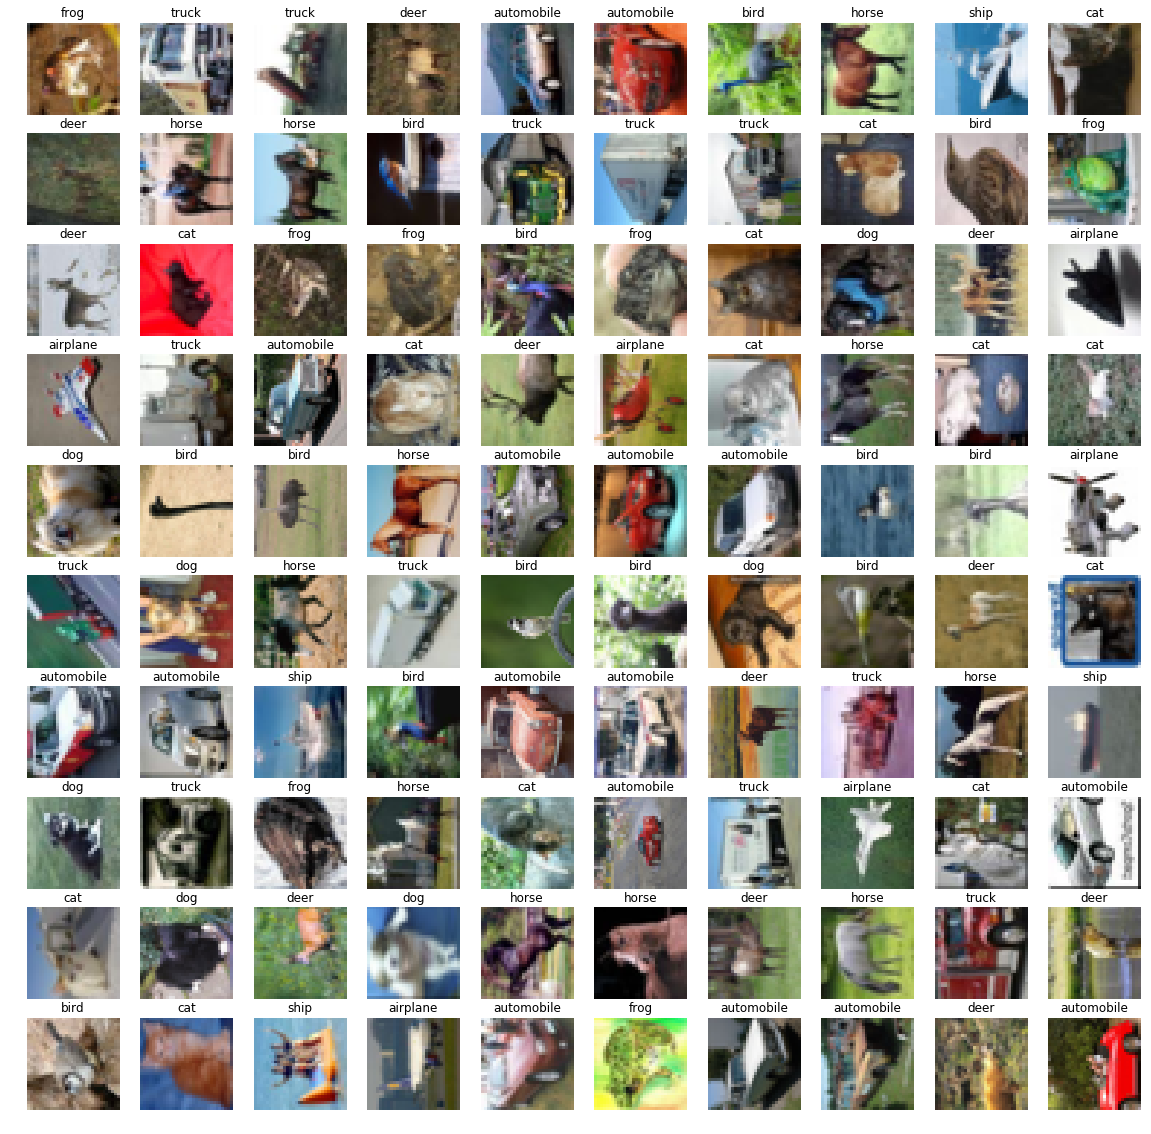

In [4]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(train_X[i])
    plt.title(label_names[np.argmax(train_Y[i])])

In [6]:
def create_CNN(input_shape, num_classes):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters = 32, padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters = 32))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters = 64, padding='same'))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters = 64))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Activation('softmax'))
    opt = tf.keras.optimizers.RMSprop(lr=1e-4, decay=1e-6)
    model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    

In [7]:
myCNN = create_CNN(train_X.shape[1:], len(label_names))

In [12]:
history = myCNN.fit(x=train_X, y=train_Y, validation_data=(test_X, test_Y), batch_size=32, epochs=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 162s 3ms/step - loss: 1.8209 - acc: 0.3323 - val_loss: 1.5413 - val_acc: 0.4371
Epoch 2/100
50000/50000 [==============================] - 167s 3ms/step - loss: 1.5011 - acc: 0.4540 - val_loss: 1.3598 - val_acc: 0.5121
Epoch 3/100
50000/50000 [==============================] - 180s 4ms/step - loss: 1.3598 - acc: 0.5132 - val_loss: 1.2435 - val_acc: 0.5581
Epoch 4/100
50000/50000 [==============================] - 159s 3ms/step - loss: 1.2682 - acc: 0.5482 - val_loss: 1.2101 - val_acc: 0.5717
Epoch 5/100
50000/50000 [==============================] - 167s 3ms/step - loss: 1.1926 - acc: 0.5786 - val_loss: 1.1194 - val_acc: 0.6060
Epoch 6/100
50000/50000 [==============================] - 169s 3ms/step - loss: 1.1332 - acc: 0.5998 - val_loss: 1.0441 - val_acc: 0.6359
Epoch 7/100
50000/50000 [==============================] - 155s 3ms/step - loss: 1.0768 - acc: 0.6217 - val_loss: 1.

In [13]:
myCNN.save('myCNN_trained.h5')

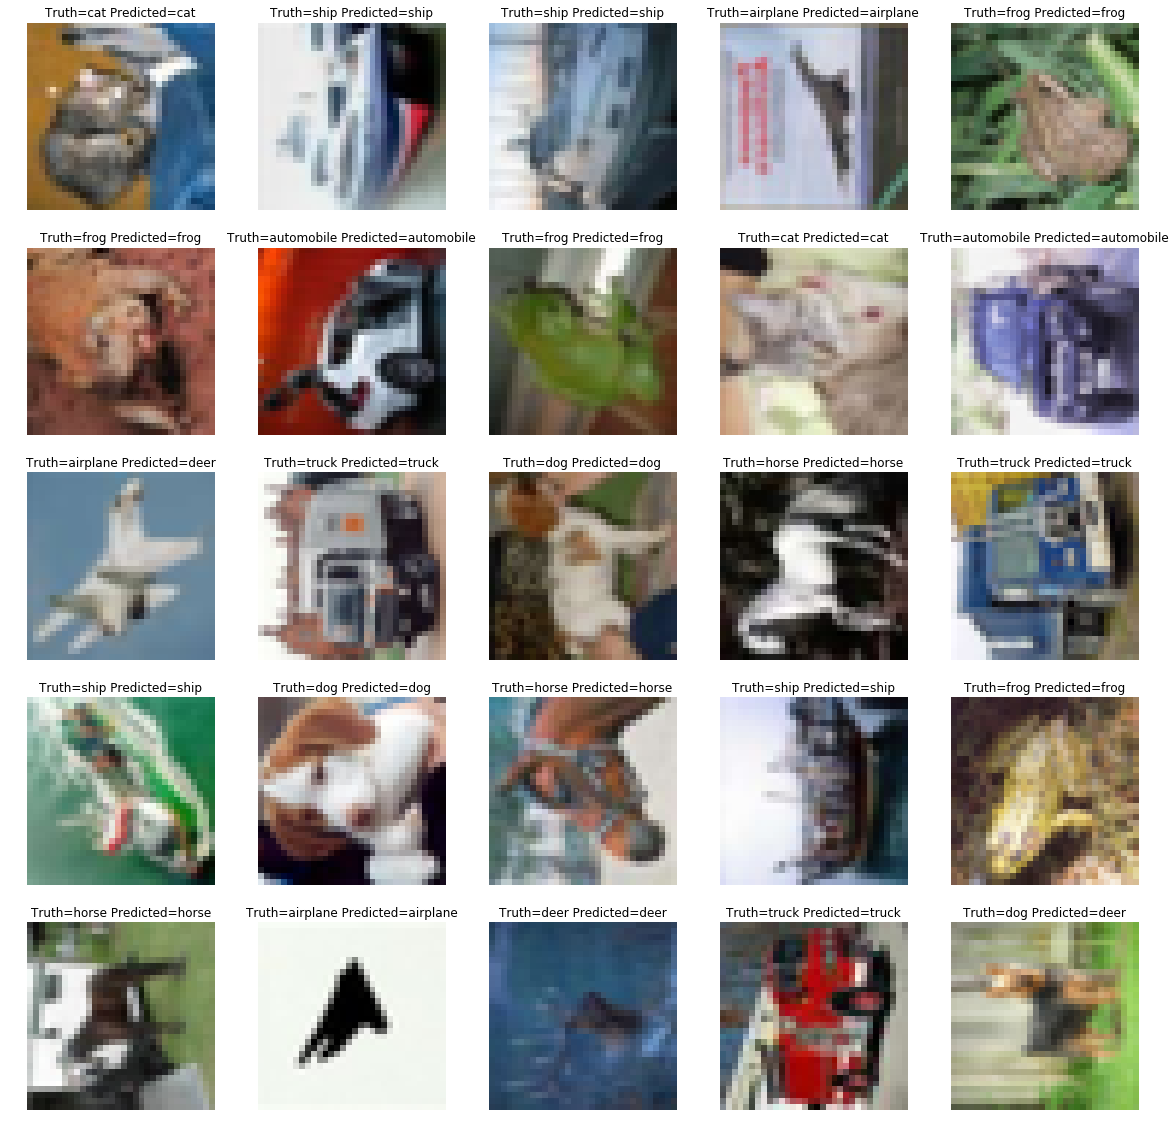

In [5]:
mymodel = tf.keras.models.load_model('myCNN_trained.h5')
preds = (mymodel.predict_classes(test_X[:25]))
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(test_X[i])
    plt.title('Truth=%s Predicted=%s' %(label_names[np.argmax(test_Y[i])], label_names[preds[i]]))

Text(0.5,1,'Pred=horse')

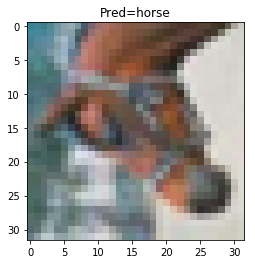

In [6]:
horse = test_X[17]
horse_copy = horse.copy()
plt.imshow(horse)
plt.title('Pred=%s' %label_names[int(mymodel.predict_classes(np.expand_dims(horse, axis = 0)))])

In [7]:
def create_fake_(i):
    print('Creating fake %s' %label_names[i])
    horse_ = horse_copy.copy()
    horse_ = np.expand_dims(horse_, axis = 0)
    min_perturbed = np.clip(horse_-0.01, 0, 1)
    max_perturbed = np.clip(horse_+0.01, 0, 1)
    input_layer = mymodel.layers[0].input
    output_layer = mymodel.layers[-1].output
    cost_fn = output_layer[0, i]
    grad_fn = tf.keras.backend.gradients(cost_fn, input_layer)[0]
    get_cost_and_grads = tf.keras.backend.function(inputs = [input_layer, tf.keras.backend.learning_phase()], outputs = [cost_fn, grad_fn])
    lr = 0.1
    cost = 0.0
    while cost<0.8:
        cost, grads = get_cost_and_grads([horse_, 0])
        print('Cost = %s' %cost)
        horse_+=grads
        np.clip(horse_, min_perturbed, max_perturbed)
    return horse_[0]

In [8]:
fake_labels = list(range(10))
fake_labels.remove(7)
fakes =[]
for label in fake_labels:
    fakes.append(create_fake_(label))

Creating fake airplane
Cost = 0.0025648577
Cost = 0.018069882
Cost = 0.089363195
Cost = 0.13523
Cost = 0.6433655
Cost = 0.29856968
Cost = 0.9919538
Creating fake automobile
Cost = 0.00015185327
Cost = 0.00019613761
Cost = 0.00026831497
Cost = 0.00039157938
Cost = 0.0006623763
Cost = 0.0013957026
Cost = 0.0049478
Cost = 0.042835034
Cost = 0.102294445
Cost = 0.43112192
Cost = 0.059567373
Cost = 0.9877389
Creating fake bird
Cost = 0.08549253
Cost = 0.37530556
Cost = 0.9391633
Creating fake cat
Cost = 0.10510377
Cost = 0.20869319
Cost = 0.9978179
Creating fake deer
Cost = 0.01557389
Cost = 0.18540038
Cost = 0.9837429
Creating fake dog
Cost = 0.25475228
Cost = 0.78176224
Cost = 0.9982723
Creating fake frog
Cost = 0.00524655
Cost = 0.12155258
Cost = 0.265029
Cost = 0.9999043
Creating fake ship
Cost = 0.0002859381
Cost = 0.0004904847
Cost = 0.0010507787
Cost = 0.0031614765
Cost = 0.024932494
Cost = 0.116683446
Cost = 0.2464691
Cost = 0.9970849
Creating fake truck
Cost = 0.0011451461
Cost = 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


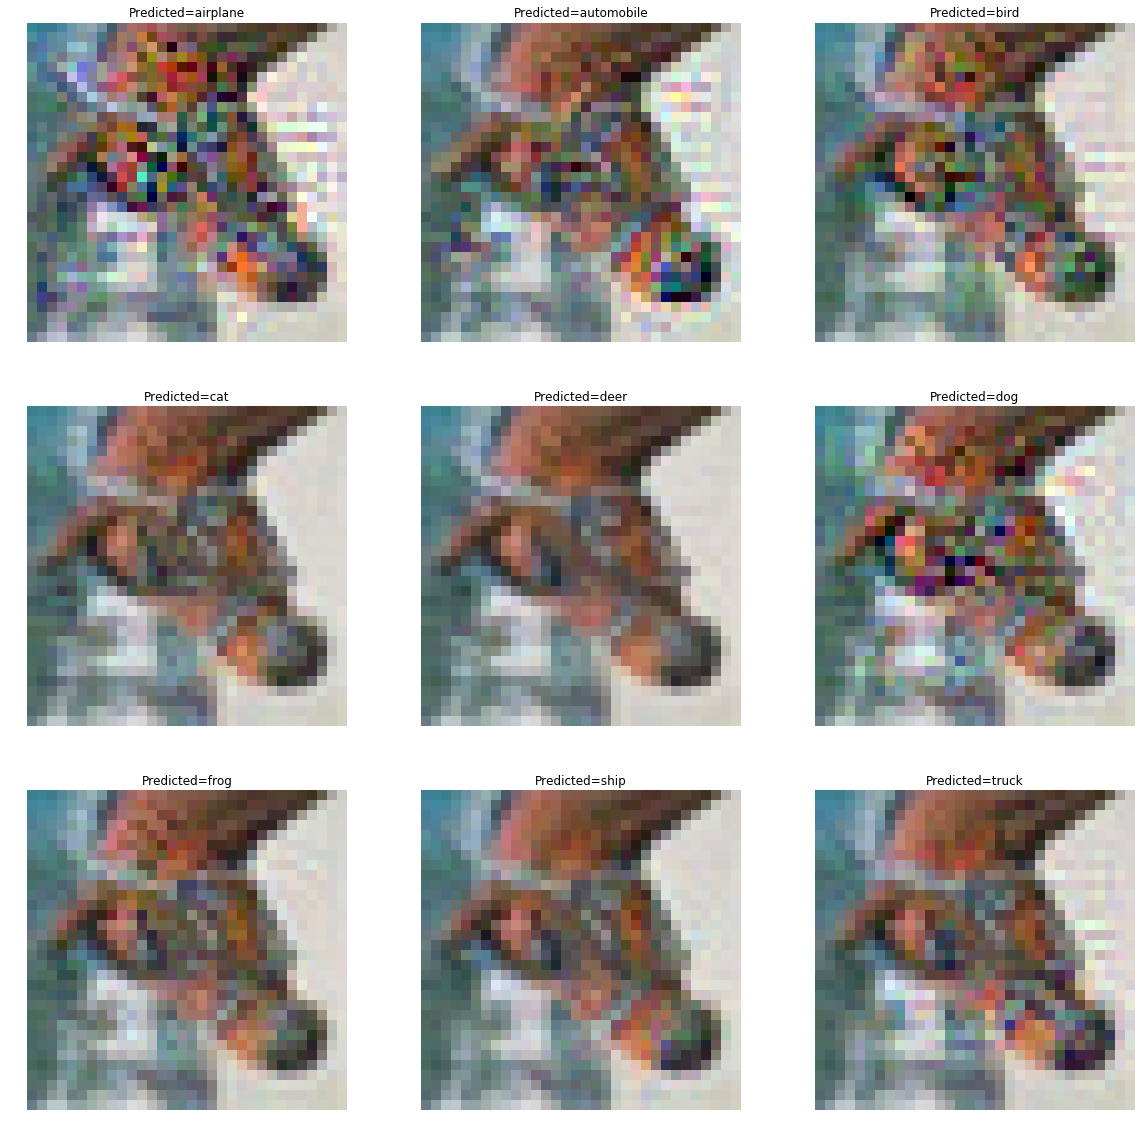

In [9]:
plt.figure(figsize=(20, 20))
for i,fake in enumerate(fakes):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(fake)
    plt.title('Predicted=%s' %label_names[int(mymodel.predict_classes(np.expand_dims(fake, axis = 0)))])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

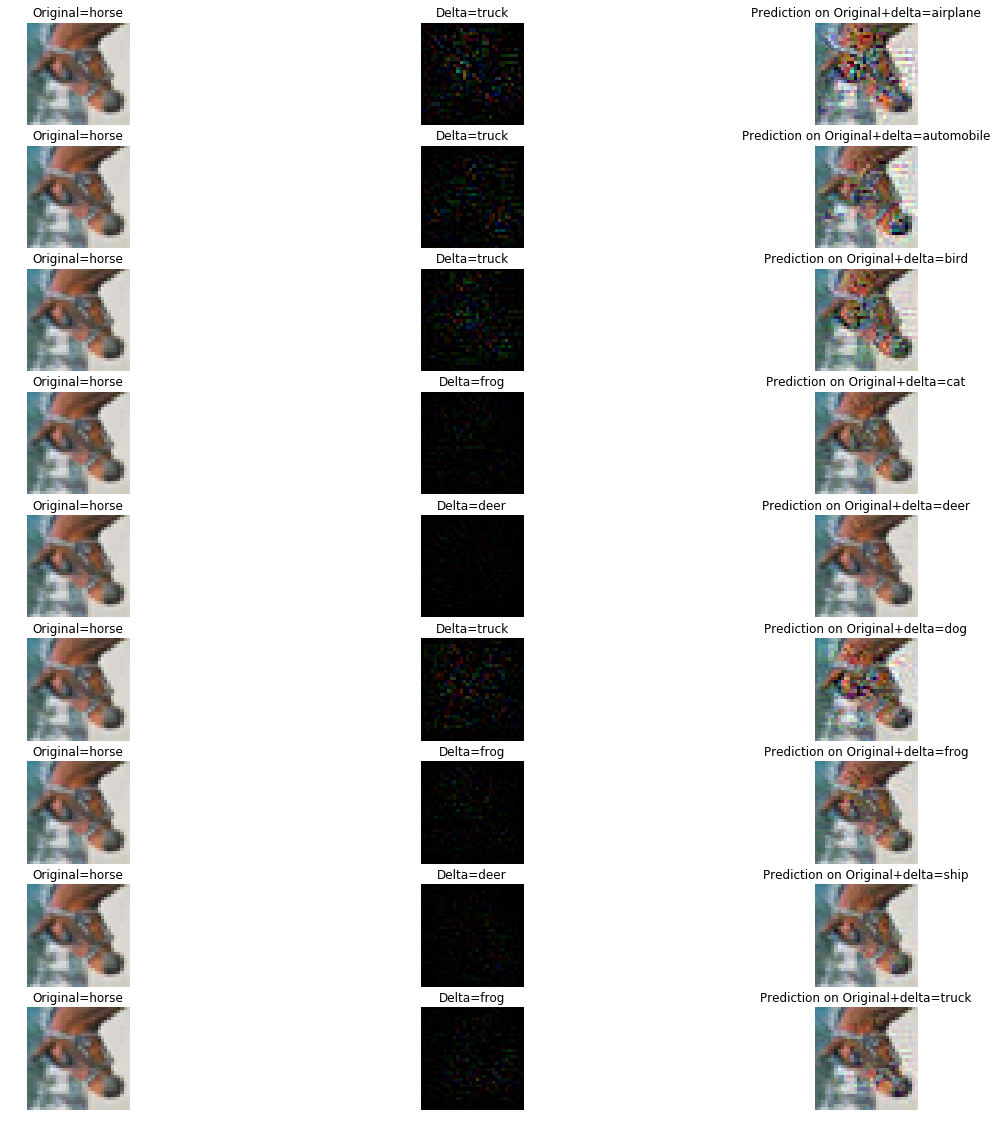

In [10]:
plt.figure(figsize=(20, 20))
for i,fake in enumerate(fakes):
    plt.subplot(9, 3, 3*i+1)
    plt.axis('off')
    plt.imshow(horse)
    plt.title('Original=%s' %label_names[int(mymodel.predict_classes(np.expand_dims(horse, axis = 0)))])
    
    plt.subplot(9, 3, 3*i+2)
    plt.axis('off')
    plt.imshow(fake-horse)
    plt.title('Delta=%s' %label_names[int(mymodel.predict_classes(np.expand_dims(fake-horse, axis = 0)))])
    
    plt.subplot(9, 3, 3*i+3)
    plt.axis('off')
    plt.imshow(fake)
    plt.title('Prediction on Original+delta=%s' %label_names[int(mymodel.predict_classes(np.expand_dims(fake, axis = 0)))])